## ریاضیات و فهم مدل

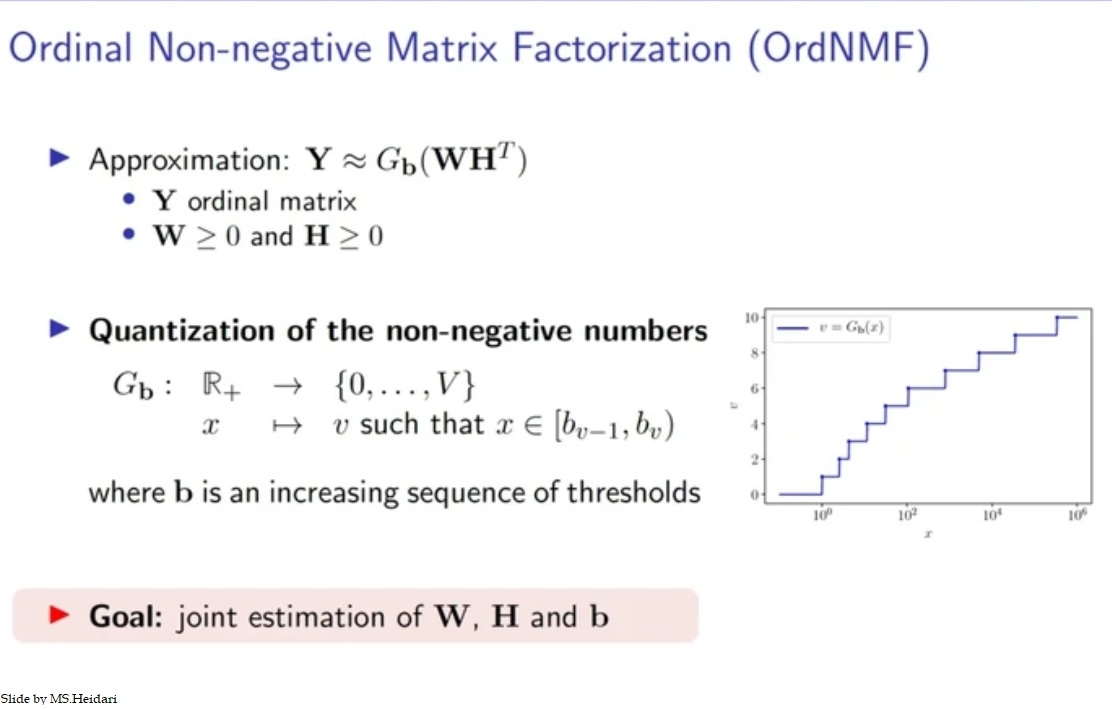

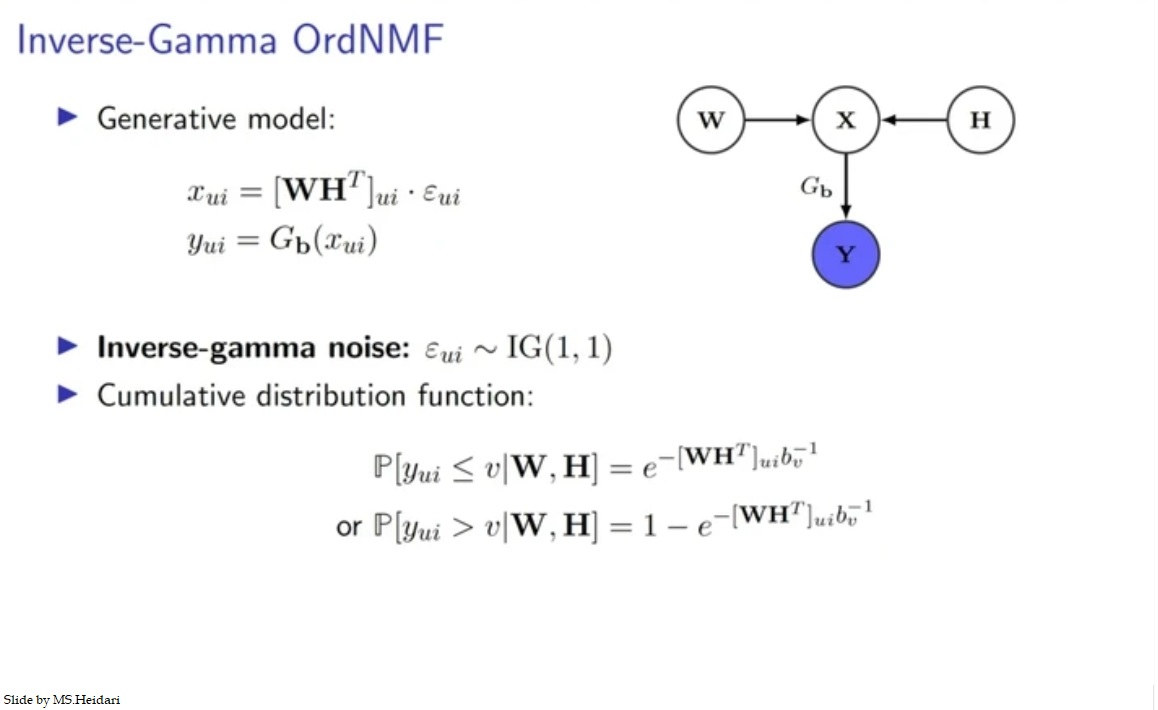

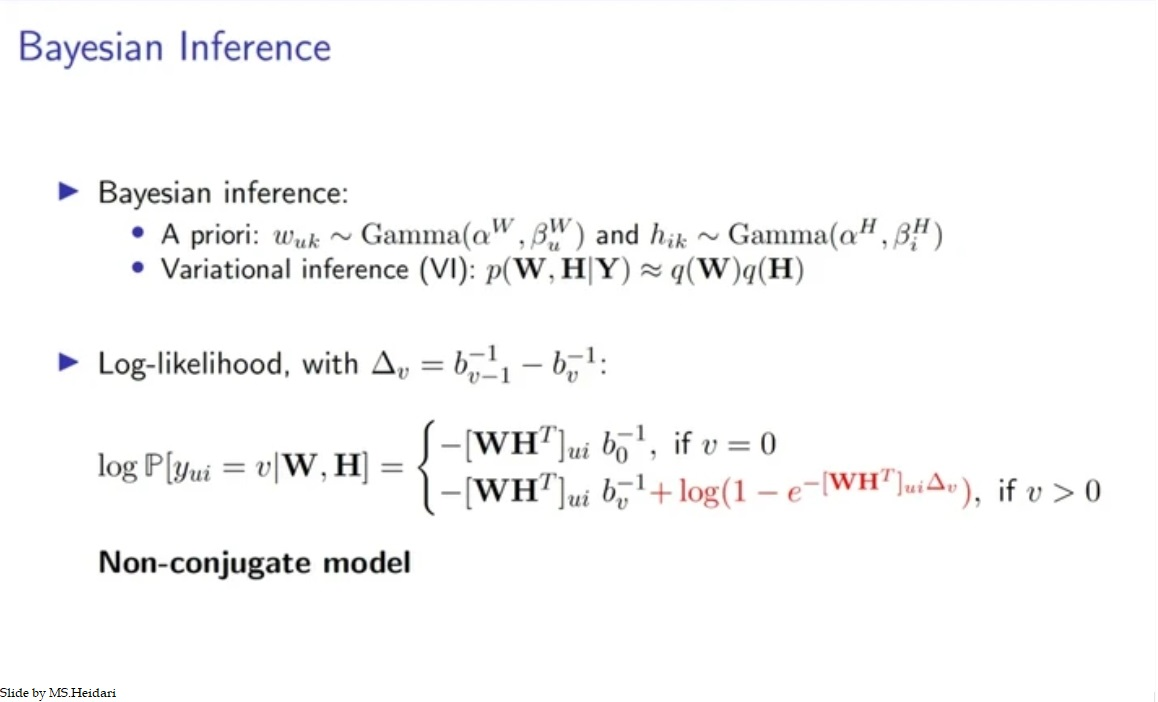

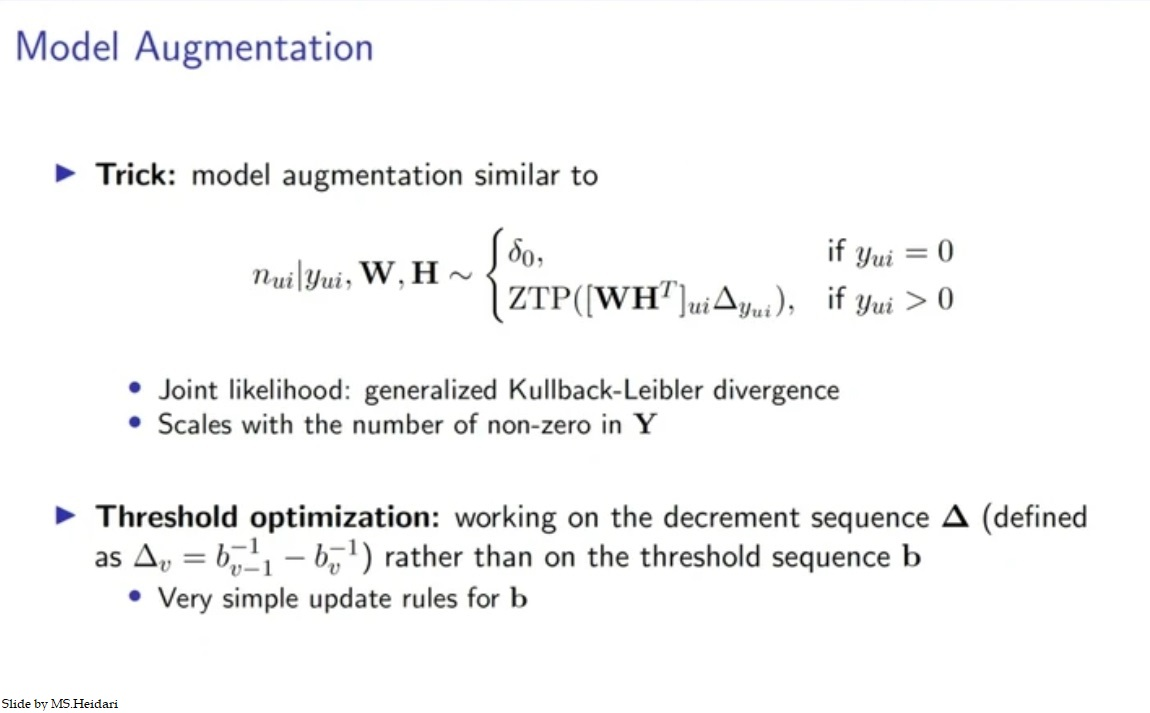

## اجرای مدل

در اینجا با استفاده از روش state به پیاده سازی Recommender System میپرد

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download netflix-inc/netflix-prize-data

 98% 668M/683M [00:05<00:00, 94.0MB/s]
100% 683M/683M [00:05<00:00, 125MB/s] 


In [ ]:
!unzip netflix-prize-data.zip -d data

Archive:  netflix-prize-data.zip
  inflating: data/README             
  inflating: data/combined_data_1.txt  
  inflating: data/combined_data_2.txt  
  inflating: data/combined_data_3.txt  
  inflating: data/combined_data_4.txt  
  inflating: data/movie_titles.csv   
  inflating: data/probe.txt          
  inflating: data/qualifying.txt     


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.special as special
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

در سلول زیر کلیه توابع موجود در متن مقاله از جمله ord-nmf با تغییر پارامترها طبق معادلات ریاضی موجود نوشته شده اند

In [ ]:
def read_data(files, title_path):

    data = open('data.csv', mode='w')
    row = list()

    for file in files:
        with open(file) as f:
            for line in f: 
                del row[:] 
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')

    data.close()

    df = pd.read_csv('data.csv', header=None, nrows = 1000000).iloc[:, :-1]
    df.columns = ['UserID', 'MovieID', 'Rating']

    movie_map = {a:i for i, a in enumerate(sorted(df['MovieID'].unique()))}
    user_map = {a:i for i, a in enumerate(sorted(df['UserID'].unique()))}

    df['MovieID'] = df['MovieID'].map(lambda a:movie_map[a])
    df['UserID'] = df['UserID'].map(lambda a:user_map[a])
    
    
    
    return df

def data_to_matrix(x, y, m_shape):

    M = sparse.csr_matrix((y,(x[:, 0], x[:, 1])), shape=(m_shape[0],m_shape[1]))

    return M

def rmse(true, pred):

    pred = pred[true != 0].flatten()
    true = true[true != 0].flatten()
    
    return np.sqrt(mean_squared_error(true, pred))

def delta_initialization(V):

    hist_values = np.bincount(V.data)
    hist_values[0] = V.nnz
    cum_hist = np.cumsum(hist_values, dtype=float)
    delta = hist_values/cum_hist
    delta[0]=0
    return delta

def q_loc(V,delta,templates,activators):

    nz_users, nz_items = V.nonzero()
    Lbd = np.sum(templates[nz_users,:]*activators[nz_items,:],1)
    delta_y = delta[V.data]

    en = Lbd*delta_y/(1-np.exp(-Lbd*delta_y))
    en[np.isnan(en)] = 1

    R = sparse.csr_matrix((en/Lbd,(nz_users,nz_items)),shape=V.shape) 
    Sw = templates*(R.dot(activators)) 
    Sh = activators*(R.T.dot(templates))

    elbo = np.sum(np.log(np.expm1(Lbd*delta_y)))
    return Sw, Sh, en, elbo

def gamma_elbo(s, r, Ex, Elogx):

    return (s-1)*Elogx -r*Ex +s*np.log(r) -special.gammaln(s)

def stat_gamma(s,r):

    E = s/r
    dig_shape = special.digamma(s)
    Elog = dig_shape - np.log(r)
    entropy = s - np.log(r) + special.gammaln(s) + (1-s)*dig_shape
    return E, Elog, entropy

def q_Gamma(s1, s2, r1, r2):

    E,Elog,entropy = stat_gamma(s1+s2, r1+r2)
    elbo = gamma_elbo(s1, r1, E, Elog)
    elbo = elbo.sum() + entropy.sum()
    return E, Elog, elbo

def ord_nmf(V, R, T = 5, iteration=1000, alphaW = 1, alphaH = 1, betaW=1, betaH = 1):
    
    num_users, num_items = V.shape
    nz_users, nz_items = V.nonzero()
    data = V.data

    delta = delta_initialization(V)
    H = (np.triu(np.ones((T+1,T+1))).dot(delta[:,np.newaxis]))[:,0] 
    theta0 = H[0]
    G = theta0 - H
    Gy = sparse.csr_matrix((G[data],(nz_users,nz_items)), shape=(num_users,num_items))

    templates = np.random.gamma(alphaW,betaW,(num_users,R))
    activators = np.random.gamma(alphaH,betaH,(num_items,R))
    s_wh = np.dot(np.sum(templates,0,keepdims=True),np.sum(activators,0,keepdims=True).T)[0,0]

    Sw, Sh, En, elboLoc = q_loc(V,delta,templates,activators)

    Elbo = [-float("inf")]

    counter = 0

    W_ERROR = []
    H_ERROR = []

    while counter <  iteration:

        betaW = alphaW/templates.mean(axis=1,keepdims=True)
        betaH = alphaH/activators.mean(axis=1,keepdims=True)

        lbd = np.sum(templates[nz_users,:]*activators[nz_items,:],1)
        S_lbd = s_wh

        for l in range(T,0,-1): 
            S_lbd = S_lbd - np.sum(lbd[V.data==l+1])
            delta[l] = np.sum(En[V.data==l])/S_lbd

        H = (np.triu(np.ones((T+1,T+1))).dot(delta[:,np.newaxis]))[:,0] 
        theta0 = H[0]
        G = theta0 - H
        Gy = sparse.csr_matrix((G[data],(nz_users,nz_items)), shape=(num_users,num_items))

        templates_prime = templates
        activators_prime = activators

        templates, Elogw, elboW = q_Gamma(alphaW , Sw, betaW, theta0*np.sum(activators,0,keepdims=True) - Gy.dot(activators))
        activators, Elogh, elboH = q_Gamma(alphaH, Sh, betaH, theta0*np.sum(templates,0,keepdims=True) - Gy.T.dot(templates))
        s_wh = np.dot(np.sum(templates,0,keepdims=True),np.sum(activators,0,keepdims=True).T)[0,0]

        Sw, Sh, En, elboLoc = q_loc(V,delta,np.exp(Elogw),np.exp(Elogh))

        elbo = elboLoc - theta0*s_wh + np.sum(templates*Gy.dot(activators)) + elboW + elboH

        if counter==0:
            rate = float('inf')
        else:
            rate = (elbo-Elbo[-1])/np.abs(Elbo[-1])

        counter += 1

        Elbo.append(elbo) 

        W_ERROR.append(np.linalg.norm(templates-templates_prime, ord=2))
        H_ERROR.append(np.linalg.norm(activators-activators_prime, ord=2))


    return templates, activators, W_ERROR, H_ERROR

def recommend(user_id, matrix, pred_matrix, num_of_rec):

    pred_user = pred_matrix[:, user_id]
    true_user = matrix[:, user_id]

    rec_dict = dict()

    for i, val in enumerate(true_user):
        if val == 0 and pred_user[i] != 0:
            rec_dict[i] = pred_user[i]

    rec_dict = dict(sorted(rec_dict.items(), key=lambda item: item[1]))
    rec_movie_id = list(rec_dict.keys())[-num_of_rec:]

    print(f"recommended movie id: {rec_movie_id}")

In [ ]:
data = read_data(['data/combined_data_1.txt', 'data/combined_data_2.txt', 'data/combined_data_3.txt', 'data/combined_data_4.txt'], 'data/movie_titles.csv')
matrix_shape = (len(data['UserID'].unique()), len(data['MovieID'].unique()))


X = data[['UserID','MovieID']].values
y = data['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X = None
y = None

train_matrix = data_to_matrix(X_train, y_train, matrix_shape)
test_matrix = data_to_matrix(X_test, y_test, matrix_shape)

data.head()

,UserID,MovieID,Rating
0,0,159639,3
1,0,88366,5
2,0,95010,4
3,0,3228,4
4,0,88509,3


In [ ]:
print(f"number of unique user : {len(data['UserID'].unique())}")
print(f"number of unique movie: {len(data['MovieID'].unique())}")

number of unique user : 225
number of unique movie: 283705


Text(0, 0.5, 'frequency')

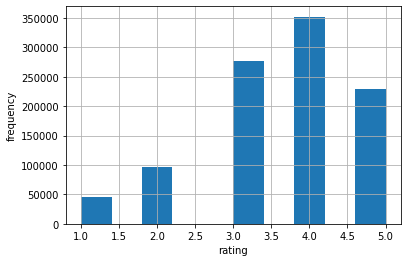

In [ ]:
data['Rating'].hist(grid=True)
plt.xlabel('rating')
plt.ylabel('frequency')

Text(0, 0.5, 'number of movie')

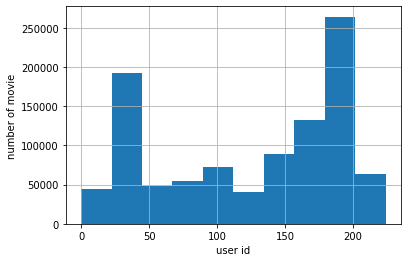

In [ ]:
data['UserID'].hist(grid=True)
plt.xlabel('user id')
plt.ylabel('number of movie')

In [ ]:
W, H, W_ERROR, H_ERROR = ord_nmf(train_matrix, 20)

[Text(0, 0.5, 'error'), Text(0.5, 0, 'period')]

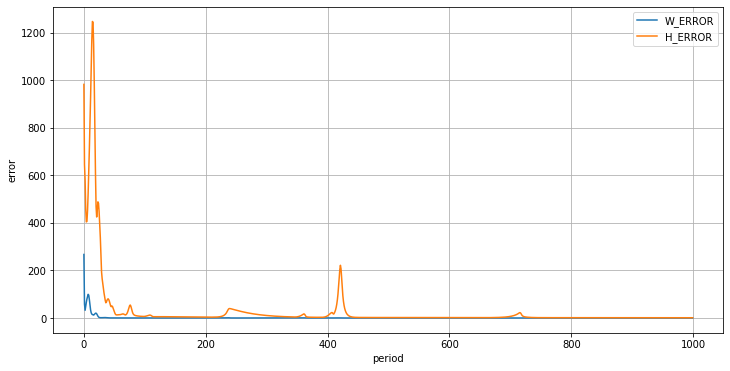

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(W_ERROR, label = 'W_ERROR')
ax.plot(H_ERROR, label = 'H_ERROR')
ax.grid()
ax.legend()
ax.set(xlabel='period', ylabel='error')

In [ ]:
pred = W.dot(H.T)
pred[pred > 5] = 5
pred[pred < 1] = 1
print(f"model rmse: {round(rmse(test_matrix.toarray(), pred), 4)}")
pred = W.dot(H.T)

model rmse: 1.7992


In [ ]:
user_id = 23
num_of_rec = 3

recommend(user_id, train_matrix.toarray(), pred, num_of_rec)

recommended movie id: [147, 107, 27]


In [ ]:
user_id = 97
num_of_rec = 3

recommend(user_id, train_matrix.toarray(), pred, num_of_rec)

recommended movie id: [198, 190, 174]
